## Finalize dataset for clustering

ML bugs

Deduplicate (pregroup)

In [9]:
# import config
import importlib
importlib.reload(config)
import config

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


## Pre-group error values based on similarity

In [1]:
import pandas as pd
import json
import config, util

df_mlerr_k = pd.read_excel(config.path_kaggle_error_process.joinpath('nberror_k_eid_p_mlbugs.xlsx'))
df_mlerr_g = pd.read_excel(config.path_github_error_process.joinpath('nberror_g_all_eid_p_mlbugs.xlsx'))

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [2]:
# filter out non-mlbugs and bugs without error values
df_mlerr_k_filtered = df_mlerr_k[(~df_mlerr_k.exp_mllib_extracted.isnull())]
len(df_mlerr_k_filtered) 

2538

In [3]:
df_mlerr_g_filtered = df_mlerr_g[(~df_mlerr_g.exp_mllib_extracted.isnull())]# &(df_mlerr_g.python_version==3))]
len(df_mlerr_g_filtered) 

36139

In [15]:
# join the two datasets
df_mlerr_k_filtered.loc[:,"nb_source"] = config.NB_SOURCE["kaggle"]
df_mlerr_g_filtered.loc[:,"nb_source"] = config.NB_SOURCE["github"]
df_mlerr_mlbugs = pd.concat([df_mlerr_g_filtered, df_mlerr_k_filtered], ignore_index=True, sort=False)
len(df_mlerr_mlbugs) 

38677

In [18]:
import cluster_util

# for jaccard similarity
df_mlerr_mlbugs["evalue_processed"] = df_mlerr_mlbugs.evalue.apply(cluster_util.preprocess_text_similarity)
# for hashing match
df_mlerr_mlbugs["evalue_tokenized"] = df_mlerr_mlbugs.evalue.apply(cluster_util.preprocess_text)
df_mlerr_mlbugs["hash_evalue_tokenized"] = df_mlerr_mlbugs.evalue_tokenized.apply(cluster_util.generateHash)

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
df_mlerr_mlbugs = df_mlerr_mlbugs[~(df_mlerr_mlbugs.evalue_processed=='')]
# there is big drop
# because of key errors. key errors tend to be only one word/the key(e.g., 'val_accuracy) in error values? 
# this will be excluded when pregrouping. preprocess_text_similarity() will delete words inside ''
len(df_mlerr_mlbugs)

36746

In [20]:
from scipy.spatial import distance
from itertools import combinations
import numpy as np

# word level similarity
data_sets = [(row["hash_evalue_tokenized"], set(row["evalue_processed"].split(" "))) for _,row in df_mlerr_mlbugs.iterrows()]

def similarity_check(t1,t2):
    if t1[0]==t2[0]:
        return 1
    return cluster_util.jaccard_similarity(t1[1], t2[1])

# hashing dup + jaccard similarity
jaccard_generator = (similarity_check(row1, row2) for row1, row2 in combinations(data_sets, r=2))
flattened_matrix = np.fromiter(jaccard_generator, dtype=np.float32)
# expand flattened_matrix (upper triangle)
sim_matrix = distance.squareform(flattened_matrix)
# set ones at the diagonal
sim_matrix += np.identity(len(df_mlerr_mlbugs))

In [21]:
import numpy as np

with open(config.path_default.joinpath("df_mlerr_mlbugs_sim_matrix_hash_jaccard.txt"), 'wb') as f:
    np.save(f, sim_matrix)
    
df_mlerr_mlbugs.to_excel(config.path_default.joinpath("df_mlerr_mlbugs.xlsx"),
                         index=False, engine='xlsxwriter')

In [24]:
cluster_util.jaccard_similarity(set(cluster_util.preprocess_text_similarity("name 'x' is not defined").split()),
                                set(cluster_util.preprocess_text_similarity("name 'head' is not defined").split()))

1.0

In [25]:
cluster_util.jaccard_similarity(set(cluster_util.preprocess_text_similarity("'GridSearchCV' object has no attribute 'best_params_'").split()),
                                set(cluster_util.preprocess_text_similarity("'Series' object has no attribute 'add'").split()))

1.0

In [26]:
# build connect matrix
connect_threshold = 0.7
connect_matrix = (sim_matrix >= connect_threshold).astype(int)
with open(config.path_default.joinpath("df_mlerr_mlbugs_connect_matrix_hash_jaccard.txt"), 'wb') as f:
    np.save(f, connect_matrix)

In [27]:
# build graph out of connect matrix, get connected subgroups=>clusters
import networkx as nx

G = nx.from_numpy_array(connect_matrix)
subgraphs = nx.connected_components(G)
res_pregroups = list(subgraphs)

In [28]:
res_labels = np.full(len(df_mlerr_mlbugs),-1)
for cluster_id in range(len(res_pregroups)):
    for index in res_pregroups[cluster_id]:
        res_labels[index]=cluster_id
df_mlerr_mlbugs["pregroup_cluster"] = res_labels

In [29]:
df_mlerr_mlbugs.to_excel(config.path_default.joinpath("df_mlerr_mlbugs_pregroup.xlsx"),
                         index=False, engine='xlsxwriter')

## Analyzing

In [2]:
import pandas as pd
import config

df_mlerr_mlbugs = pd.read_excel(config.path_default.joinpath('df_mlerr_mlbugs_pregroup.xlsx'))

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


<Axes: xlabel='pregroup_cluster'>

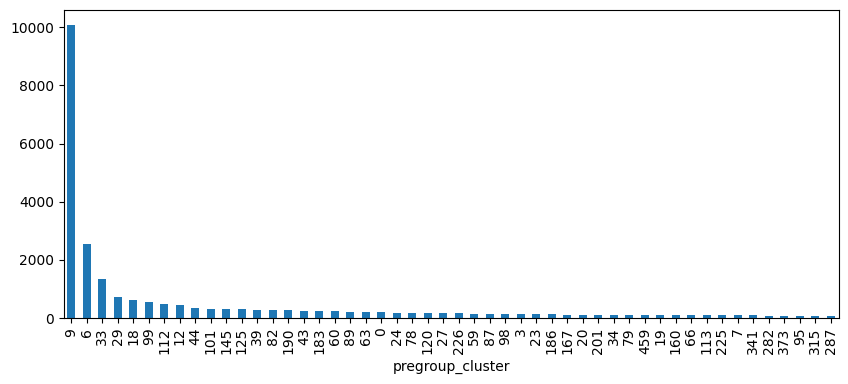

In [40]:
df_mlerr_mlbugs_cluster_size = df_mlerr_mlbugs.groupby("pregroup_cluster").size().sort_values(ascending=False)
df_mlerr_mlbugs_cluster_size.iloc[:50].plot(kind="bar", figsize=(10,4))

In [38]:
# check some corelation with exception types
for i in range(30):
    cluster_id = df_mlerr_mlbugs_cluster_size.index[i]
    cluster_size = df_mlerr_mlbugs_cluster_size.iloc[i]
    print("Top {} cluster with size {}. Exception types include:".format(i,cluster_size))
    print("Example:",df_mlerr_mlbugs[df_mlerr_mlbugs.pregroup_cluster==cluster_id].evalue.iloc[0])
    print((df_mlerr_mlbugs[df_mlerr_mlbugs.pregroup_cluster==cluster_id].ename).value_counts(), "\n")

Top 0 cluster with size 10090. Exception types include:
Example: name 'train_classifications' is not defined
ename
nameerror                 10079
undefinedvariableerror       11
Name: count, dtype: int64 

Top 1 cluster with size 2549. Exception types include:
Example: 'numpy.ndarray' object has no attribute 'obseru_smooth'
ename
attributeerror          2533
moduleattributeerror      14
typeerror                  1
unknownerror               1
Name: count, dtype: int64 

Top 2 cluster with size 1339. Exception types include:
Example: [Errno 2] No such file or directory: '0.png'
ename
filenotfounderror    1298
notfounderror          21
drivererror            11
unknownerror            3
ioerror                 2
oserror                 2
error                   1
filecreateerror         1
Name: count, dtype: int64 

Top 3 cluster with size 734. Exception types include:
Example: module 'numpy' has no attribute 'linespace'
ename
attributeerror    734
Name: count, dtype: int64 

Top 4 clu

In [65]:
print((df_mlerr_mlbugs_cluster_size.cumsum()/df_mlerr_mlbugs.eid.nunique()).searchsorted(0.8)) # num of clusters needed for cover certain percent of errors

cutoff_cluster_size = 16
print(sum(df_mlerr_mlbugs_cluster_size>=cutoff_cluster_size)) # num of clusters needed for cluster size over ceratin number
print(sum(df_mlerr_mlbugs_cluster_size[df_mlerr_mlbugs_cluster_size>=cutoff_cluster_size])/df_mlerr_mlbugs.eid.nunique()) # percentage

228
242
0.8059108474391771


<Axes: xlabel='pregroup_cluster'>

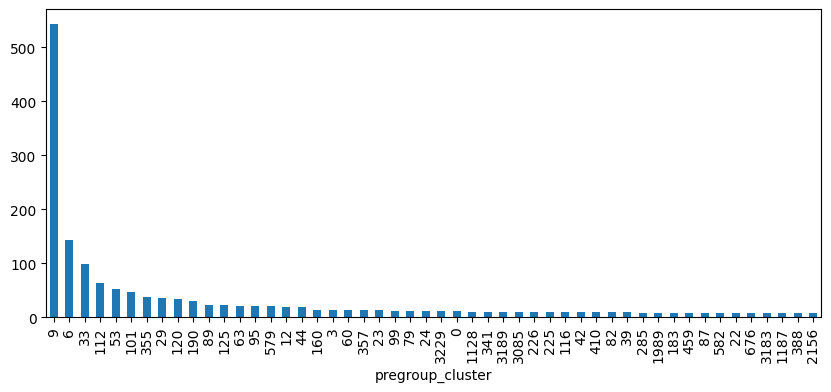

In [43]:
# separate plot github and kaggle and select top clusters
# kaggle
df_mlerr_mlbugs_k = df_mlerr_mlbugs[df_mlerr_mlbugs["nb_source"]==config.NB_SOURCE["kaggle"]].reset_index(drop=True)
df_mlerr_mlbugs_cluster_size_k = df_mlerr_mlbugs_k.groupby("pregroup_cluster").size().sort_values(ascending=False)
df_mlerr_mlbugs_cluster_size_k.iloc[:50].plot(kind="bar", figsize=(10,4))

In [70]:
print((df_mlerr_mlbugs_cluster_size_k.cumsum()/df_mlerr_mlbugs_k.eid.nunique()).searchsorted(0.8)) # num of clusters needed for cover certain percent of errors

cutoff_cluster_size_k = 3
print(sum(df_mlerr_mlbugs_cluster_size_k>=cutoff_cluster_size_k)) # num of clusters needed for cluster size over ceratin number
print(sum(df_mlerr_mlbugs_cluster_size_k[df_mlerr_mlbugs_cluster_size_k>=cutoff_cluster_size_k])/df_mlerr_mlbugs_k.eid.nunique()) # percentage

126
142
0.8201013513513513


<Axes: xlabel='pregroup_cluster'>

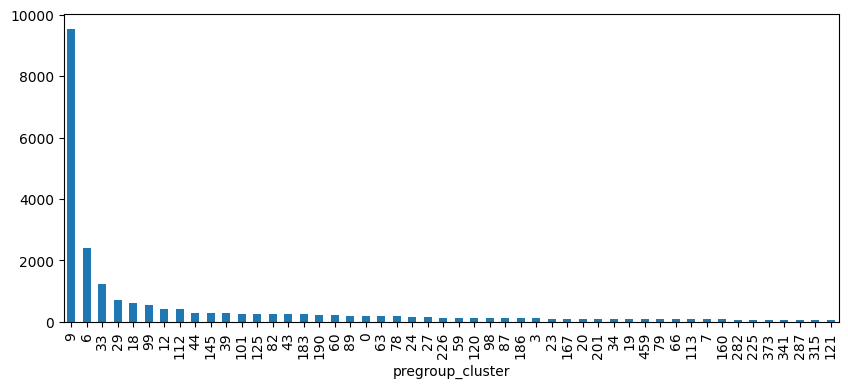

In [44]:
# github
df_mlerr_mlbugs_g = df_mlerr_mlbugs[df_mlerr_mlbugs["nb_source"]==config.NB_SOURCE["github"]].reset_index(drop=True)
df_mlerr_mlbugs_cluster_size_g = df_mlerr_mlbugs_g.groupby("pregroup_cluster").size().sort_values(ascending=False)
df_mlerr_mlbugs_cluster_size_g.iloc[:50].plot(kind="bar", figsize=(10,4))

In [69]:
print((df_mlerr_mlbugs_cluster_size_g.cumsum()/df_mlerr_mlbugs_g.eid.nunique()).searchsorted(0.8)) # num of clusters needed for cover certain percent of errors

cutoff_cluster_size_g = 15
print(sum(df_mlerr_mlbugs_cluster_size_g>=cutoff_cluster_size_g)) # num of clusters needed for cluster size over ceratin number
print(sum(df_mlerr_mlbugs_cluster_size_g[df_mlerr_mlbugs_cluster_size_g>=cutoff_cluster_size_g])/df_mlerr_mlbugs_g.eid.nunique()) # percentage

222
234
0.8053406248181977


In [71]:
# take union
df_mlerr_mlbugs_cluster_size_g[df_mlerr_mlbugs_cluster_size_g>=cutoff_cluster_size_g].index.union(
    df_mlerr_mlbugs_cluster_size_k[df_mlerr_mlbugs_cluster_size_k>=cutoff_cluster_size_k].index)

Index([   0,    2,    3,    5,    6,    7,    8,    9,   10,   12,
       ...
       3195, 3226, 3228, 3229, 3244, 3252, 3255, 3262, 3268, 3271],
      dtype='int32', name='pregroup_cluster', length=284)

In [73]:
df_mlerr_mlbugs_unique = df_mlerr_mlbugs.drop_duplicates(subset=['pregroup_cluster'], keep='last')
df_mlerr_mlbugs_unique.to_excel(config.path_default.joinpath("df_mlerr_mlbugs_pregroup_dedup.xlsx"), index=False, engine='xlsxwriter')